<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/full_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random



# workflow notebook

Used reference:
-  [git in colab](https://www.geeksforgeeks.org/how-to-install-and-use-git-in-google-colab/)!

# 0. Open ipynb from github
To get this latest notebook from our repo into colab:
> "Open in colab" button == {Download from github} + {Upload to colab} - {Gets saved to drive}

# 1. Set up project in runtime
Copy the following cell and run it with your credentials to clone the repo, getting datasets as runtime files, and then delete your credentials.

In [2]:
!git config --global user.email "h.stuart.livingstone@gmail.com"
!git config --global user.name "StuartLiv"
!git clone https://[token]@github.com/StuartLiv/CPSC-440-Project

fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.


In [3]:
%pwd

'/content'

`git clone` seems too good to be true for getting a few GB of data into runtime, but `/datasets/` is up once clone is run! See:

In [4]:
path = '/content/CPSC-440-Project/datasets/largeset_multisize/color'
files = os.listdir(path)
print(files)

['16369.jpg', '10151.jpg', '17307.jpg', '12423.jpg', '11666.jpg', '17146.jpg', '14195.jpg', '13230.jpg', '3352.jpg', '7103.jpg', '2653.jpg', '1698.jpg', '7192.jpg', '11373.jpg', '3759.jpg', '15720.jpg', '14910.jpg', '3645.jpg', '14642.jpg', '7754.jpg', '5862.jpg', '9318.jpg', '12885.jpg', '9917.jpg', '8134.jpg', '6126.jpg', '6416.jpg', '13221.jpg', '16213.jpg', '2136.jpg', '14747.jpg', '4363.jpg', '264.jpg', '3484.jpg', '12773.jpg', '5155.jpg', '5483.jpg', '6797.jpg', '1488.jpg', '9826.jpg', '11588.jpg', '4741.jpg', '17901.jpg', '7952.jpg', '3715.jpg', '6380.jpg', '444.jpg', '18009.jpg', '14947.jpg', '3029.jpg', '14282.jpg', '587.jpg', '13041.jpg', '15567.jpg', '10022.jpg', '5104.jpg', '9385.jpg', '14610.jpg', '173.jpg', '2729.jpg', '18049.jpg', '7064.jpg', '16034.jpg', '799.jpg', '13108.jpg', '13183.jpg', '7767.jpg', '7996.jpg', '5799.jpg', '6733.jpg', '14986.jpg', '10470.jpg', '16165.jpg', '5189.jpg', '11954.jpg', '7153.jpg', '1096.jpg', '2125.jpg', '2790.jpg', '3479.jpg', '6194.jpg'

# 2. Preprocess data

Datasets:
- `smallset_onesize` [DEPRECATED - DO NOT USE]
  - Downloaded as is, [here](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization).
  - 7130 color/gray pairs
  - Res 150x150
  - 0.232GB
- `largeset_multisize` [USE THIS ONE]
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 18329 color/gray pairs. (actually 18328 - had to delete photo 2507 due to strange resolution issues)
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)
  - 401 MB



In [5]:


''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = cv.imread(path + '/'+i,1)
    img = img.astype('float32') / 255
    arr.append(img_to_array(img))

  return arr


In [6]:
color_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/color')

100%|██████████| 18328/18328 [00:08<00:00, 2066.26it/s]


In [7]:
gray_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/gray')

100%|██████████| 18328/18328 [00:08<00:00, 2253.99it/s]


6787


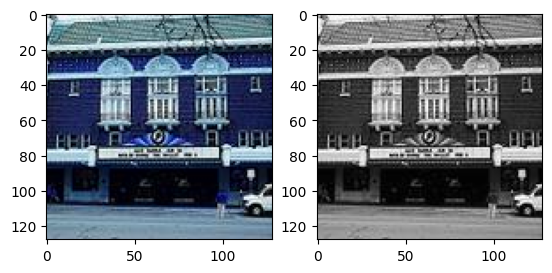

6550


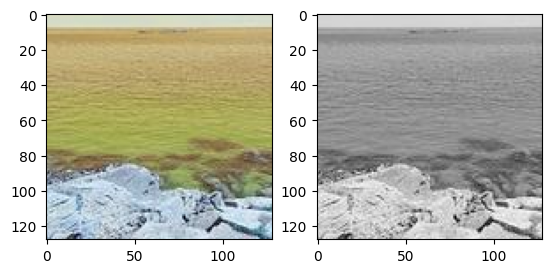

8487


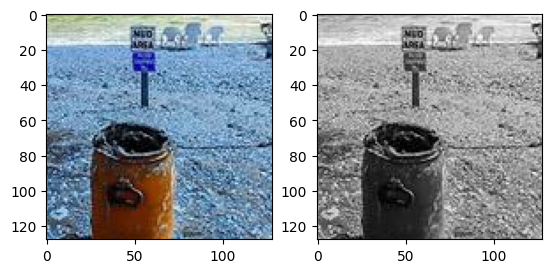

13465


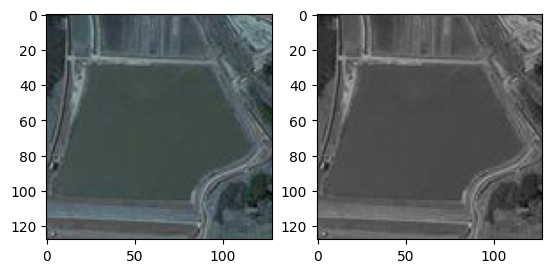

In [8]:

for i in np.random.randint(len(color_arr),size=4):
  print(i)
  plt.subplot(1,2,1)
  plt.imshow(color_arr[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_arr[i])
  plt.show()

In [9]:
# Make a tensor list of reformatted images (based on Stuarts's axis swap)
gray_tensors = []

for image in gray_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    gray_tensors.append(t)

color_tensors = []

for image in color_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    color_tensors.append(t)

# 3. Model
Toy model generated below:

In [10]:
# prompt: pytorch colourization autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()



Train toy model (GD):

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(gray_arr)):
        if (gray_tensors[i].size() != torch.Size([3, 128, 128])):
          continue # turns out there are some non-square images (like maybe 5 or 10 total) in the original smallset dataset, and so they're here too... temporary fix

        inputs = gray_tensors[i].unsqueeze(0)  # Add batch dimension
        targets = color_tensors[i].unsqueeze(0)  # Add batch dimension

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(gray_arr)))

print('Finished Training')

KeyboardInterrupt: 

Train Toy Model (SGD, cheaper for small experiments):

Findings based on experiments:

Densifying convolutions ie two layers between pooling did not show much improvement, but is more expensive.

3x3 less blurry than 5x5, experiments into varied sizes not conducted

L1 seemingly had more mode collapse? hard to compare losses.

Notably, the small loss issue was due to float rescaling in the \[0-1\] range, so not the \[0-255\] int range we were expecting. Conceptually this is less punishing for being far away? Interpretability is also a bit worse, but I think we want to keep the problem continuous for general ease of use, otherwise it starts to be "softmax-y"

ReLU or clipping worse than Sigmoid last layer.

It doesn't really make much sense to use Adam for GD, since its built for stochastic processes, ie why consider past gradients if all the values in the batches are the same? We can either commit to SGD+Adam or just do GD

Blurryness demonstrated to decrease with more iterations.

Weight decay has a meaningful impact on blurryness, probably something we don't want at the moment. Worth reconsidering in longer runs.

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=0.0001)

# Training loop
num_iterations = 1
batch_size=4
for iteration in range(num_iterations):
    running_loss = 0.0
    batch_indexes = torch.randint(high=len(gray_arr), size=(batch_size,1))

    print(batch_indexes)
    print(gray_tensors[batch_indexes])

    inputs = gray_tensors[i].unsqueeze(0)  # Add batch dimension
    targets = color_tensors[i].unsqueeze(0)  # Add batch dimension

    optimizer.zero_grad()
    outputs = autoencoder(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    if (iteration % 100 == 0): print('[%d] loss: %.3f' % (iteration, running_loss / batch_size))

print('Finished Training')

tensor([[ 1057],
        [11737],
        [12098],
        [14339]])


TypeError: only integer tensors of a single element can be converted to an index

tensor(0.8855, grad_fn=<MaxBackward1>)


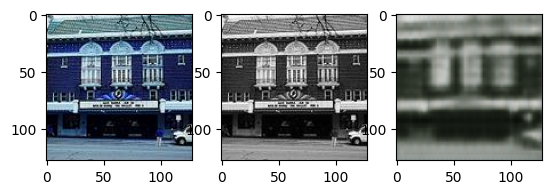

In [ ]:
rand_index = random.randint(0, 18000)

image_bw = gray_arr[rand_index]
image_c = color_arr[rand_index]

# Colorize the image
t = torch.from_numpy(np.moveaxis(image_bw, [2, 1], [0,2]))
colorized_image = autoencoder(t)
colorized_image_format = np.moveaxis(colorized_image.detach().numpy(), [1,2], [0,1])

print(colorized_image.max())

plt.subplot(1,3,1)
plt.imshow(image_c)
plt.subplot(1,3,2)
plt.imshow(image_bw)
plt.subplot(1,3,3)
plt.imshow(colorized_image_format)
plt.show()

# LEFT TO RIGHT: ORIGINAL, GRAYSCALE, COLORIZED

# Visualize model

Using [pytorchviz](https://github.com/szagoruyko/pytorchviz)!

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

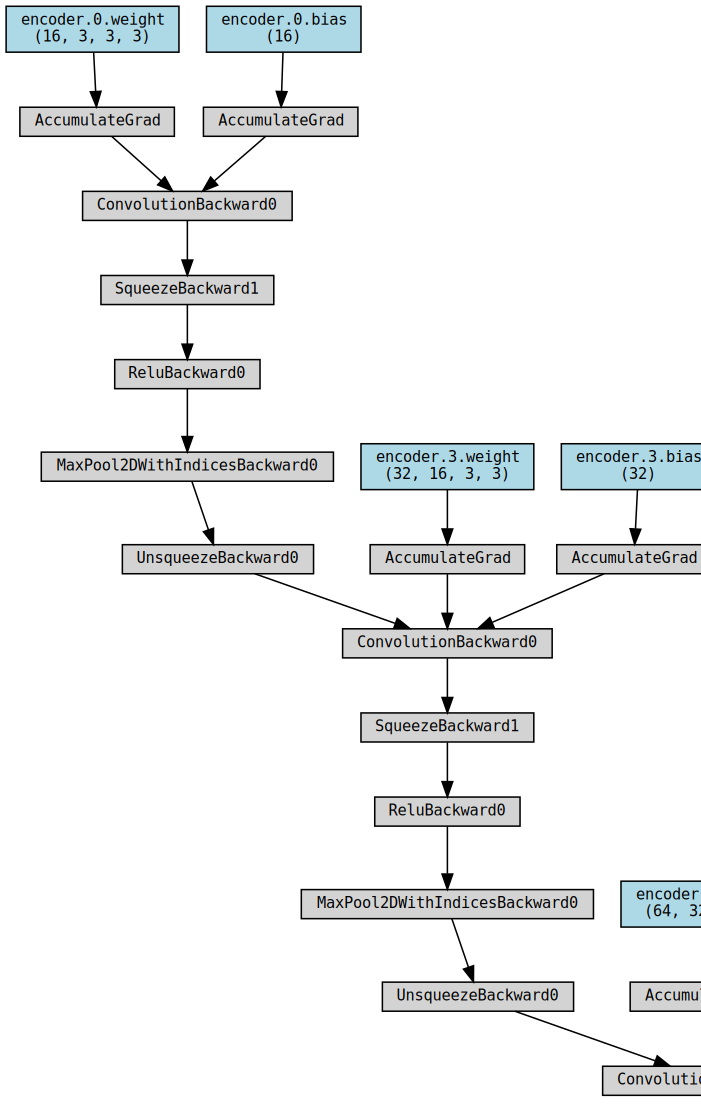

In [ ]:
from torchviz import make_dot
make_dot(colorized_image.mean(), params=dict(autoencoder.named_parameters()))

In [ ]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/v0/decoder_weights')

In [ ]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/v0/encoder_weights')

# Load model

In [ ]:
autoencoder.decoder = torch.load('/content/CPSC-440-Project/v0/decoder_weights')
autoencoder.encoder = torch.load('/content/CPSC-440-Project/v0/encoder_weights') # need some weights saved here!

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
!git add .

In [ ]:
!git status

In [ ]:
!git commit -m "Message here"

In [ ]:
!git push

# 5. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!